# A/B - тесты

## Вводные

**ТЗ:** ML команда сделала некоторые новые алгоритмы рекомендаций в новостной ленте. Ожидается, что новые алгоритмы сделают пользователей счастливее, то есть удлинится LTV, повысятся денежные конверсии и т.д., а продукт удобнее/приятнее в использовании. Необходимо проверить эту гипотезу.

**Обследование области**

Команда ML сказала нам «Рекомендации делают посты интереснее». Сделано было два новых алгоритма рекомендаций:

1) Показываем пользователю посты, наиболее похожие на те, которые он лайкал.
2) Показываем пользователю посты, которые лайкали похожие на него пользователи.

**Выбор метрики**

Показатель, увеличение которого будет говорит, что посты стали интереснее (a.k.a продукт стал удобнее):

- Время, проведенное в ленте
- Количество просмотренных постов в единицу времени
- Количество лайков
- CTR из просмотров в лайки

Возьмем CTR потому что есть явное действие, которое показывает заинтересованность – лайк.

**Подготовка А/B-теста**

Перед запуском A/B-теста, хорошим тоном считается провести А/А-тестирование. Для того, чтобы грамотно его провести - необходимо соблюсти следующие условия:
- Разбиение должно быть случайным (потому что мы хотим, чтобы наши группы отличались только воздействием и показатели группы отражали показатели генеральной совокупности)
- У каждого пользователя в течение эксперимента не должна меняться группа (потому что мы не хотим, чтобы пользователь видел оба варианта алгоритма, мы хотим независимости выборок)
- Способ разбиения должен быть детерминированным (чтобы можно было, если нужно, в точности повторить разбиение, например если мы захотим проверить взаимодействия этих алгоритмов с какой-то новой функциональностью, например "каруселью" с популярными историями)

# Оглавление <a id='root'></a> 
* [Проверка готовности к A/B-тестированию](#0)
    * [Проверка системы сплитования](#1)
    * [A/A-тестирование](#2)
    * [Вывод о системе сплитования и результатах A/A-теста](#3)
* [A/B-тест](#4)
    * [Графики распределения](#5)
    * [Проверка условий использования t-теста](#6)
    * [Проверка гипотезы критерием Манна-Уитни](#7)
    * [Проверка условий использования критерия Манна-Уитни](#7.5)
    * [Сглаживание по Лапласу](#8)
    * [Проверка гипотезы на сглаженных данных](#9)
    * [Проверка гипотезы Пуассоновским бутстрепом](#10)
    * [Проверка гипотезы бакетным преобразованием](#11)
    * [Вывод о результах A/B-тестирования](#12)
* [Проверка результатов А/В-тестирования по методу Яндекса](#13)

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import numpy as np
import loggins_and_passwords as connect


Можем разбить наших пользователей на группы самостоятельно

In [2]:
def ab_split(id, salt='exp_mess_1', n_groups=4):
    """
    ab_split(id, salt='exp_mess_1', n_groups=4):
    Разбиение пользователей на группы для А/Б тестов с использованием соленого хеша
    """
    
    test_id = str(id) + '-' + str(salt)
    test_id_digest = hashlib.md5(test_id.encode('ascii')).hexdigest()
    test_id_final_int = int(test_id_digest, 16)
    return test_id_final_int % n_groups

Тоже самое можно сделать и в Clickhouse

```
SELECT xxHash64(toString(user_id)||'exp_mess_1')%5 as group, 
    uniqExact(user_id)
FROM {db}.feed_actions 
WHERE toDate(time) >= '2022-03-28' and toDate(time) <= '2022-04-03' 
group by group 
```

Но, мы знаем, что пользователи уже разбиты на группы и даже в БД им присвоен номер группы. А сам A/A-тест проходил с 28 марта по 3 апреля 2022 года. Поэтому, чтобы проверить результаты необходимо проверить систему сплитования. Будем проверять ее на 2 и 3 группе пользователей.

# Проверка готовности к A/B-тестированию <a id='0'></a> 

## Проверка системы сплитования <a id='1'></a> 

Для начала выгрузим данные и посчитаем количество пользователей в каждой из групп. Их должно быть примерно равное количество.

In [3]:


connection = {'host': connect.host,
                      'database':connect.database,
                      'user':connect.user, 
                      'password':connect.password
                     }

query = '''
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-03-28' and '2022-04-03'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


Распределение пользователей по группам выглядит более менее. Проверим это на графике.

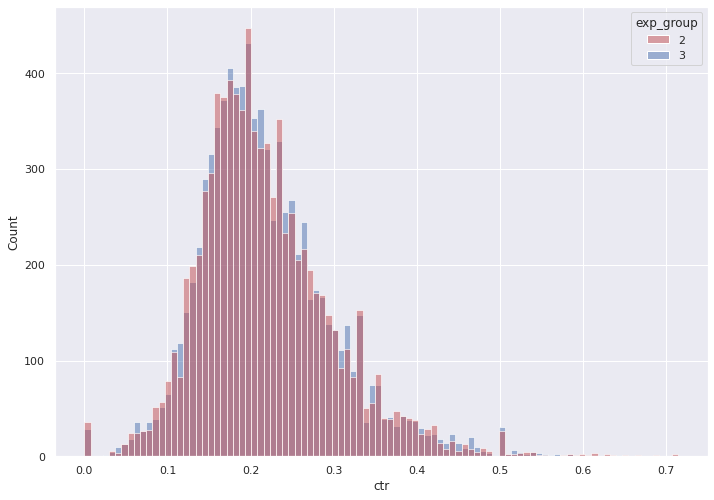

In [4]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Отлично. Разбиение визуально похоже на случайное. Более детально мы это проверим при А/А-тестировании. А пока проверим, правда ли у наших пользователей остается неизменная группа на протяжении всего эксперемента

In [5]:
df.query('exp_group in(2,3)').pivot_table(index='user_id', values= 'exp_group', aggfunc = lambda x: len(x.unique())).reset_index().query('exp_group>1')


,user_id,exp_group


Супер, группа не изменяется. Теперь посмотрим, что скажет нам t-тест, если мы его запустим 10к раз на подвыборках из 500 пользователей?

[К оглавлению](#root)

## A/A- тест <a id='2'></a> 

In [6]:
p_arr = []
for _ in range(10000):
    t_stat = stats.ttest_ind(df[df.exp_group == 2].ctr.sample(500),
                            df[df.exp_group == 3].ctr.sample(500),
                            equal_var=False)

    p_arr.append(t_stat[1])

<AxesSubplot:ylabel='Count'>

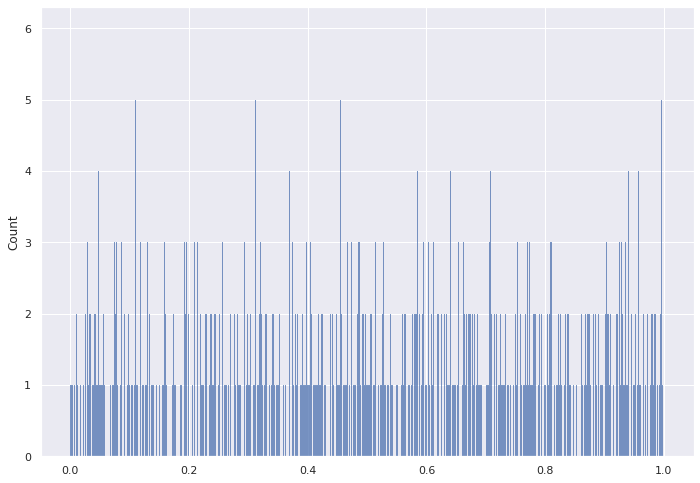

In [7]:
sns.histplot(x=p_arr, kde=False, bins=10000)



Выглядит уже не очень здорово, но это только выглядит. Чтобы тест был признан удачным (на уровне значимости 0.05) - мы должны получать p-value меньше либо равное 0.05 только в 5% случаев. Проверим это 

In [8]:
print(f'мы получили значение p-value меньше 0.05 в {len([i for i in p_arr if i<=0.05])/len(p_arr)*100}% случаев')

мы получили значение p-value меньше 0.05 в 4.54% случаев


## Вывод A/A-тестирования <a id='3'></a> 
На уровне значимости 0.05 мы можем принять гипотезу о том, что наша система сплитования работает нормально. Только в 4.75% случаев мы получили значение p-value меньше либо равное 0.05, т.е., вероятность случайно получить такое или еще большее различие между 2 и 3 группой пользователей - менее 5%. Кроме того, мы знаем, что у нас выполняется условие неизменности группы у пользователя в ходе эксперемента.

[К оглавлению](#root)

# A/B-тестирование <a id='4'></a> 

После того, как было проведено А/А-тестирование, был запущен А/В-тест, который проходил с 4 апреля по 10 апреля включительно 2022 года. Для эксперемента были задействованны группы 1 и 2. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Нам необходимо проанализировать результаты

In [9]:
query = '''
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Группы у нас распределились примерно одинаково. Посмотрим на гистограмму  <a id='5'></a> 

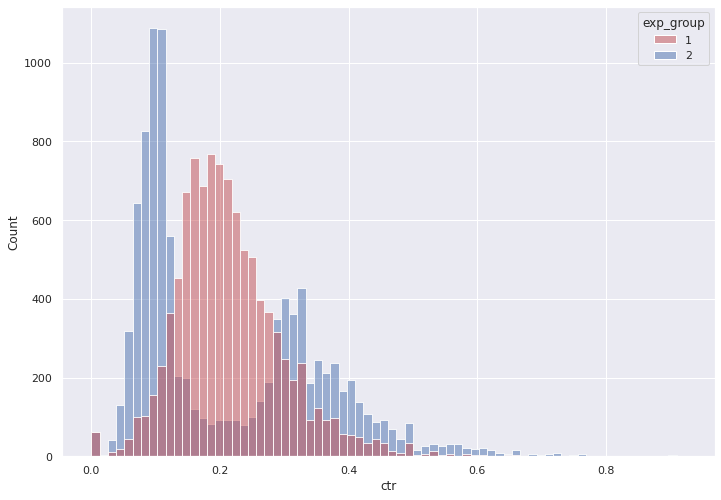

In [10]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Сказка... У второй группы, показатель которой мы ожидаем величить - бимодальное распределение. Скорее всего, t-критерий не сможет адекватно оценить результаты, потому что, как миниму, t-тест плохо работает на сильно скошенных распределениях, а распределение пользователей во 2 группе как раз такое. 


[К оглавлению](#root)


Кроме того, было бы неплохо проверить условия применимости t-критерия, а для этого нужно их вспомнить: <a id='6'></a> 

- некоррелируемость признаков
- нормальность распределения признаков
- гомогенность дисперсий признаков

С первым пунктом все понятно - действия независимые и выполнены разными пользователями, неизменность групп которых мы подтвердили проверяя систему сплитования. А вот второй и третий критерий применимости t-критерия - нужно проверять.

Для проверки на нормальность можно использовать, например тест Шапиро-Вилка. При этом, нужно понимать, что даже отвергание гипотезы о нормальности распределения не дает однозначного запрета на использование критерия Стьюдента потому что доказано, что при больших выборках (где n>30) требование нормальности распределения для t-критерия является необязательным.

При проверрке на гомогенность дисперсии можно использовать критерий Фишера. Тут важно помнить, что в отличае от t-теста, для F-критерия требование нормальности распределений является обязательнымзатем и, в случае нарушения этого требования, можно легко, без регистраций и смс, получить неадекватные результаты. Поэтому, если вдруг наши выборки распределены не нормально, то следует использовать какой-либо непараметрический аналог, например тест Крускала-Виллиаса (он, кстати, хорошо работает если выборки разного размера).


In [11]:
def can_we_use_t_test(sample_1, sample_2, alpha=0.05):
    
    """
    can_we_use_t_test(sample_1, sample_2, alpha=0.05)
    проверяет условия использования t-критерия Стъюдента
    для сравнения средних 2х выборок.
    sample_1 - numpy array
    sample_2 - numpy array
    alpha - уровень значимости
    """

    # проверим распределения на нормальность
    shapiro_1 = stats.shapiro(sample_1).pvalue
    shapiro_2 = stats.shapiro(sample_2).pvalue

    # проверим гомогенность дисперсии
    var_1 = (sample_1 - sample_1.mean())**2
    var_2 = (sample_2 - sample_2.mean())**2

    var_1_shapiro = stats.shapiro(var_1).pvalue
    var_2_shapiro = stats.shapiro(var_2).pvalue

    if var_1_shapiro >= alpha and var_2_shapiro >= alpha:

        F = np.var(sample_1) / np.var(sample_2)
        df_1 = len(sample_1)-1
        df_2 = len(sample_2)-1
        homogeneity_p = 1 - st.f.cdf(F, df_1, df_2)

    else:
        homogeneity_p = stats.kruskal(sample_1, sample_2).pvalue



    if (shapiro_1 >= alpha or (shapiro_1 < alpha and len(sample_1) > 30)) and \
     (shapiro_2>= alpha or (shapiro_2 < alpha and len(sample_2)>30)) and \
     homogeneity_p > alpha:

        print('проверяем гипотезу по Стьюденту')
    else:
        print('следует выбрать другой критерий')
        
        
can_we_use_t_test(df[df.exp_group == 1].ctr.values, df[df.exp_group == 2].ctr.values)

следует выбрать другой критерий


/nfs/env/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


[К оглавлению](#root)

 <a id='7'></a> Окей, Стъюдентом нельзя. Можно попробовать Манна-Утни, но чтоб точно получить адекватный результат - проверим сразу условия выполнения нулевой гипотезы теста: вероятность того, что случайно взятое значение из первой выборки равновероятно окажется больше или меньше случайно взятого значения из второй выборки.

In [12]:
def can_we_use_Mann(sample_1, sample_2, k):
    """
    can_we_use_Mann(sample_1, sample_2)
    
    расчитывает в каком % испытаний показатель случайно взятый из перво выборки больше показателя случайно взятого из второй
    sample_1 - numpy array
    sample_2 - numpy array
    k - количество испытаний
    """
    get_A_B = 0
    for i in range(k):
        get_A_B += sample_1.sample().values[0]>sample_2.sample().values[0]

    print(f'в {get_A_B/100}% случаев значение CTR взятое из 1 группы больше значения CTR из второй. Должно получиться в райне 50%')

can_we_use_Mann(df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr, 10000)

в 56.29% случаев значение CTR взятое из 1 группы больше значения CTR из второй. Должно получиться в райне 50%


Получается, что тест Манна-Уитни говорит нам, что CTR первой группы больше CTR второй. Это не тот результат который бы мы хотели увидеть, поэтому проверим его более тщательно.

[К оглавлению](#root)

Условя применимости теста Манна-Уитни: <a id='7.5'></a> 
- В каждой из выборок должно быть не менее 3 значений признака. Допускается, чтобы в одной выборке было два значения, но во второй тогда не менее пяти.
- В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10).

Первое условие у нас выполняется (мы знаем, что в каждой из выборок около 10к значений, а вот второе надо проверять.


In [13]:
def can_we_use_Mann_2(samples_list):
    """
    can_we_use_Mann_2(samples_list)
    считает количество повторяющихся значений в выборке.
    если повторяющихся значений больше 10 - критерий Манна-Уитни использовать нельзя.
    
    samples_list (list) - список в котором каждый элемент - список значений метрики
    
    """
    for sample in samples_list:
        un_val = sample.to_list()
        count_dic = {}
        for el in un_val:
            count_dic[el] = 0

        for el in un_val:
            count_dic[el]=count_dic[el]+1

        print(f'количество совпадающих значений в выборке {len([k for k,v in count_dic.items() if v>1])}')

can_we_use_Mann_2([df[df.exp_group == 1].ctr, df[df.exp_group == 2].ctr])

количество совпадающих значений в выборке 999
количество совпадающих значений в выборке 1065


Получили гораздо больше, чем 10 совпадающих значений в каждой из выборок. Значит мы не можем пологаться на результаты теста Манна-Уитни. Попробуем оценить как-нибудь по другому

[К оглавлению](#root)

<a id='8'></a> Есть предположение, что наши данные сильно зашумлены и у пользователей с малым количеством просмотров мы просто не в состоянии набрать достаточную статистику, чтобы сделать вывод о его CTR. Поэтому попробуем сгладить CTR и проверить можем ли мы использовать эти 2 теста на сглаженном CTR, а сглаживать будем по Лапласу.


In [14]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    """
    get_smothed_ctr(user_likes, user_views, global_ctr, alpha)
    считает сглаженный ctr  по Лапласу
    """
    
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    
    return smothed_ctr

query = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

df= ph.read_clickhouse(query, connection=connection)

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()


sample_1 = df[df.exp_group == 1].ctr.copy()
sample_2 = df[df.exp_group == 2].ctr.copy()

sample_1['smoothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
sample_2['smoothed_ctr'] = df.apply(lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

In [15]:
can_we_use_t_test(sample_1.smoothed_ctr.values, sample_2.smoothed_ctr.values)

can_we_use_Mann_2([sample_1.smoothed_ctr, sample_2.smoothed_ctr])

проверяем гипотезу по Стьюденту
количество совпадающих значений в выборке 2702
количество совпадающих значений в выборке 2702


[К оглавлению](#root)



<a id='9'></a> Классно. Мы можем проверить нашу гипотезу и t-тестом. Сделаем это и не забудем, что наша нулевая гипотеза не о равенстве средних, а о том, что CTR в группе 2 больше чем в группе 1. 

In [16]:
print('проверяем гипотезу по Стьюденту')
print('вероятность случайно получить такие или еще большие отличая средних - {:.2%}'.format(
                                                                                            stats.ttest_ind(
                                                                                            sample_1.smoothed_ctr.values,
                                                                                            sample_2.smoothed_ctr.values, 
                                                                                            alternative='less').pvalue)
                                                                                             )


проверяем гипотезу по Стьюденту
вероятность случайно получить такие или еще большие отличая средних - 85.33%


Тут бы мы могли и остановиться, сказав, что-то вроде "Ну все, мы не можем подтвердить на уровне значимости в 0.05 то, что после введения нового рекомендательного алгоритма CTR- вырос". Но, как всегда, есть два "но": 
- первое (относится к нашему случаю): результаты нашего теста зависят от выбора константы сглаживание - не хорошо это, где есть константы там есть субъективизация
- второе (относится к случаю, когда тесты красятся, но не нашему): нет никаких теоретических гарантий на тест проведенный поверх сглаженного CTR, что направления изменения сглаженного и реального CTR будут сонаправленны. Другими словами - мы можем использовать этот метод, но только на свой страх и риск. Мы не можем гарантировать, что получив на сглаженном CTR оценку в минус на реальном CTR мы не получим оценку в плюс (и наоборот).

Поэтому, вместо того, чтобы сглаживать CTR по пользователям - попробуем ~~"серебрянную пулю"~~ сагрегировать его по группам и использовать бутстреп, т.е. генерировать из наших выборок подвыборки с возвращением длинны наших выборок. Если мы будем после каждой генерации подвыборок считать средние значения по подвыборкам и запоминать их, то на выходе получим распределения средних, которое по закону больших чисел будет с достаточной степенью описывать среднее генеральной совокупности (а еще получим возможность стоить доверительный интервал). 

Однако, этот метод работает оооочень долго на больших выборках, поэтому чтобы его ускорить можем не генерировать подвыборки с возвращением, а считать, сколько раз каждый из элементов попадет в выборку - это будет быстрее. В итоге получим биномиальное распределение и его проблема будет заключаться в том, что если мы сложим все частоты попадания элементов в выборку - мы можем получить сумму частот больше длинны выборки (это конечно будет небольшая погрешность, но она будет). 

[К оглавлению](#root)


<a id='10'></a> 
Нам также известно, что при достаточно большом размере выбокри биномиальное распределение вида 
$$binomial(n, 1/n) = Poisson(1)$$ 
т.е. переходит в расспределение Пуасона, а оно не зависит от длинны выборки, что позволяет значительно ускорить процесс бутстрапа 

<AxesSubplot:ylabel='Count'>

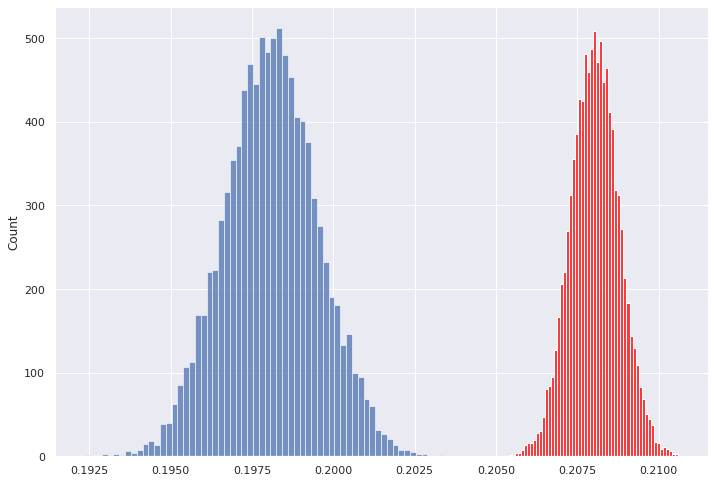

In [17]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000):
    """
    bootstrap(likes1, views1, likes2, views2, n_bootstrap=10000)
    функция Пуассоновского бутстрепа.
    Возвращает глобальные CTR первой и второй выборок расчитанные на n_bootstrap количестве подвыборок и исходных выборок
    """

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1, color='red')
sns.histplot(ctr2)

Не плохо, мы явно видем, что наши распределения не пересекаются. Но разность бутстрап-ctr второй и первой группы явно отрицательная, а значит алгоритм рекомендаций, все-таки, не работает и ухудшает CTR

<AxesSubplot:ylabel='Count'>

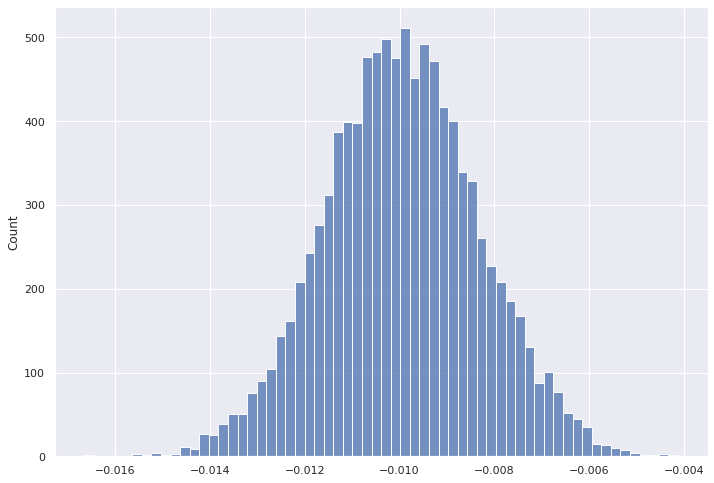

In [18]:
sns.histplot(ctr2 - ctr1)

[К оглавлению](#root)


<a id='11'></a> 
Также, можно применить логику бутстрепа, но с другой стороны и попробовать протестировать гипотезу методом бакетного преобразования.
Этот метод широко используется в индустрии (промышленные системы А/В-тестирования, такие как у Яндекса или VK) потому как он значительно быстрее бутстрапа.

Суть данного метода заключается в том, что мы разбиваем каждую из наших выборок на k-корзин, в каждой из которых равное количество пользователей и рассматриваем каждую корзину как "1 мета-пользователя". Таким образом мы момжем почтитать среднее (или любой другой показатель) внутри каждого бакета и получить выборку из k- элементов интересующего нас показателя для каждой из выборок, которые у нас есть в начале. А уже к этим выборкам из k-элементов мы можем применить t-тест или критерий Манна-Уитни.

При использовании этого метода нам нужно, чтобы соблюдались 2 условия:
- пользователь может принадлежать только к 1 бакету
- пользователи по бакетам должны быть распределены +/- равномерно

Эти условия очень напоминают условия разбиения пользователей на группы при подготовке к А/А тестированию, поэтому тут тоже можно использовать хэширование с солью.

Также у нас есть проблема с выбором количества пользователей в корзине (в мета-пользователе). Как и в случае со сглаженным CTR - выбор константы может повлиять на результат. Поэтому, чтобы избежать этого будем смотреть на лучшие практики в индустрии: во-первых, если их применяют - значит их как-то проверяли, во-вторых - попробуем разобраться почему именно их. В индустрии обычно берут количество корзин равное 100 или 200. Почему? Потому что согласно ЦПТ с ростом числа элементов в выборке ее среднее сходятся к истиному среднему, а на практике мы можем убедиться, что сходятся оно достаточно быстро и при размере выборки в 100 или 200 мы получим распределение похожее на нормальное.

Таким образом, поделим наши выборки на 50 корзин (10к пользователей по 200 пользователей в бакете - это 50 бакетов), и сравним средние значения CTR мета-пользователей.

In [19]:
query = """
SELECT 
    exp_group, 
    bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (
    SELECT exp_group,
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions
    WHERE 
        toDate(time) between '2022-04-04' and '2022-04-10'
        and exp_group in (1,2)
    GROUP BY 
        exp_group, bucket, user_id
)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(query, connection=connection)


In [20]:
can_we_use_t_test(df[df.exp_group == 1].bucket_ctr.values, df[df.exp_group == 2].bucket_ctr.values)

следует выбрать другой критерий


In [21]:
can_we_use_Mann_2([df[df.exp_group == 1].bucket_ctr, df[df.exp_group == 2].bucket_ctr])

количество совпадающих значений в выборке 0
количество совпадающих значений в выборке 0


Отлично, условия применимости Манна-Утни выполнены.

In [22]:
can_we_use_Mann(df[df.exp_group == 1].bucket_ctr, df[df.exp_group == 2].bucket_ctr, 10000)

в 79.16% случаев значение CTR взятое из 1 группы больше значения CTR из второй. Должно получиться в райне 50%


In [23]:
stats.mannwhitneyu(
                    df[df.exp_group == 1].bucket_ctr,
                    df[df.exp_group == 2].bucket_ctr, 
                    alternative='two-sided').pvalue

2.859963936492646e-07

Отлично! Бакетное преобразование подтвердило результаты Пуассоновского бутстрепа: на уровне значимости в 0.05 бакетный CTR пользователей из 1 группы больше аналогичного показателя пользователей из 2 группы. При этом у нас близкая к нулю вероятность получения такого или еще более значимого различия между группами. 

[К оглавлению](#root)

## Вывод А/B- тестирования <a id='12'></a> 

Мы проверили нашу гипотезу о том, что CTR пользователей второй группы (в которой был применен новый алгоритм) возрастает относительно первой (контрольной) группы. Проверка происходила методом Пуассоновского бутстрапа и бакетоного преобразования. Проверка выявила, что мы не можем принять нашу  гипотезу, более того, согласно данным и Пуассоновского бутстрепа и бакетного преобразования - CTR второй группы даже падает. ***Этот алгоритм рекомендации нельзя выкатывать в прод.***

Также мы пытались проверять гипотезу следующими методами:
- t-тест на чистых данных (не соблюдаются условия применимости t-теста, скорее всего из-за бимодальности распределения тестовой группы нарушается условие гомоскедостичности дисперсии)
- Манн-Уитни на чистых данных (не соблюдаются условия применимости теста)
- t-тест на сглаженных по Лапласу данных (результаты зависят от константы сглаживания, нет теоретических гарантий на соноправленность результатов теста запущенного поверх сглаженной метрики) 

[К оглавлению](#root)

# Еще один тест результатов A/B - тестирования <a id='13'></a> 

Есть огромное количество полезных материалов на тему того, какие еще способы проверки гипотез можно применять к метрикам отношений, например материалы Никиты Маршалкина <a href='https://vkteam.medium.com/practitioners-guide-to-statistical-tests-ed2d580ef04f#d2d3'>например материалы Никиты Маршалкина</a>  . или его <a href = 'https://www.youtube.com/watch?v=gljfGAkgX_o&t=19s'>интервью</a>.

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас) вида  
$$\frac{x}{y}$$ в нашем случае $$ctr = \frac{likes}{views}$$

Идея метода заключается в следующем:

Вместо того, чтобы использовать поюзерные CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если мы увидим изменения на этой новой метрики, то изменения есть и в исходной метрик (т.е. в поюзерном CTR)

Алгоритм метода прост:

1) считается общий CTR в контрольной группе  $$CTR_{control} = \frac{\sum(likes)}{\sum(views)}$$

2) в контрольно и тестовой группах считается поюзерная метрика в $$linearized\_likes = likes - CTR_{control} \times {views} $$ 

3) сравнивается t-тестом linearized_likes контрольной и тестовой группы

In [24]:
query = '''
SELECT 
    exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-04-04' and '2022-04-10'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
'''

df = ph.read_clickhouse(query, connection=connection)

ctr_control = df[df['exp_group']==1].likes.sum()/df[df['exp_group']==1].views.sum()
#𝑙𝑖𝑛𝑒𝑎𝑟𝑖𝑧𝑒𝑑_𝑙𝑖𝑘𝑒𝑠=𝑙𝑖𝑘𝑒𝑠−𝐶𝑇𝑅𝑐𝑜𝑛𝑡𝑟𝑜𝑙∗𝑣𝑖𝑒𝑤𝑠
linearized_likes_control = df[df['exp_group']==1].likes - ctr_control * df[df['exp_group']==1].views
linearized_likes_test = df[df['exp_group']==2].likes - ctr_control * df[df['exp_group']==2].views



print('вероятность случайно получить такие или еще большие отличая средних - {:.2%} при условии проверки гипотезы о том, что наш CTR вырос'.format(
                                                                                            stats.ttest_ind(
                                                                                            linearized_likes_control.values,
                                                                                            linearized_likes_test.values, 
                                                                                            alternative='less').pvalue)
                                                                                             )

print('вероятность случайно получить такие или еще большие отличая средних - {:.2%} при условии проверки гипотезы о том, что наш CTR упал'.format(
                stats.ttest_ind(
                linearized_likes_test.values, 
                linearized_likes_control.values,
                alternative='less').pvalue))

print('вероятность случайно получить такие или еще большие отличая средних - {:.2%} при условии проверки гипотезы о том, что наш CTR отличается'.format(
                stats.ttest_ind(
                linearized_likes_test.values, 
                linearized_likes_control.values,
                alternative='two-sided').pvalue)) 

вероятность случайно получить такие или еще большие отличая средних - 100.00% при условии проверки гипотезы о том, что наш CTR вырос
вероятность случайно получить такие или еще большие отличая средних - 0.00% при условии проверки гипотезы о том, что наш CTR упал
вероятность случайно получить такие или еще большие отличая средних - 0.00% при условии проверки гипотезы о том, что наш CTR отличается


Как видно из результатов - данный способ хорошо работает и тоже подтвержает результаты Пуассоновского бутстрапа и бакетного преобразования. При этом p-value стали еще более уверенные.

[К оглавлению](#root)